# Dynamics in the mapped space $[0,1]$

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.colors as mplcolors
import numpy as np
from scipy import stats
from neurodyn import *

## Integral formulation

Now we don't bin the neurons, we directly simulate the integral

In [ ]:
# TODO : this needs to be harmonized with the LowRankRNNParams.new_valentin function (this is just a copy-paste)

def rho(z):
	"""R^p PDF
	
	Parameters
	----------
	z : np.ndarray of shape (N, p)
		position in R^p

	Returns
	-------
	np.ndarray of shape (N,)
		values of the PDF at the points ``z``
	"""
	return 1/np.sqrt(2*np.pi)*np.exp(-np.linalg.norm(z, axis=1)**2/2)

def phi(z):
	return sigmoid(z)

z0 = np.random.default_rng(42).normal(loc=0, scale=1, size=1_000_000)
phi_z0 = phi(z0)
a, c = np.mean(phi_z0), np.var(phi_z0)

def phi_tilde(z):
	return (phi(z) - a) / c

def w(z, y):
	"""Connectivity kernel from position ``y`` to ``z``
	
	Parameters
	----------
	z : np.ndarray of shape (N, p)
		receiving position in R^p
	y : np.ndarray of shape (N, p)
		emitting position in R^p

	Returns
	-------
	np.ndarray of shape (N,)
		values of the connectivity kernel between ``y`` and ``z``
	"""
	return (phi_tilde(y) * z).sum(axis=1)

In [ ]:
def compute_J_ab_integral_naive(mapping, Z):
	# slow way
	J = np.zeros((mapping.num_bins, mapping.num_bins))

	for beta in range(mapping.num_bins):
		for alpha in range(mapping.num_bins):
			J[alpha, beta] += w(Z[alpha][None, :], Z[beta][None, :])
		J[:, beta] *= rho(Z[beta][None, :])

	J /= rho(Z).sum()
	return J

def compute_J_ab_integral_naive2(mapping, Z):
	J = np.zeros((mapping.num_bins, mapping.num_bins))

	for beta in range(mapping.num_bins):
		J[:, beta] += w(Z, Z[beta][None, :]) * rho(Z[beta][None, :])

	J /= rho(Z).sum()  # renormalize
	return J

def compute_J_ab_integral(mapping, Z):
	return np.einsum('im,jm,j->ij', Z, phi_tilde(Z), rho(Z)) / rho(Z).sum()

def compute_J_ab_integral_lowrank(mapping, Z):
	return LowRankRNNParams(
		phi=sigmoid, I_ext=zero, exclude_self_connections=False,
		# NOTE : we need to scale by mapping.num_bins, because the to_dense() method divides by N=num_bins again
		F=Z, G=phi_tilde(Z) * rho(Z)[:, None]/rho(Z).sum() * mapping.num_bins
	).to_dense().J

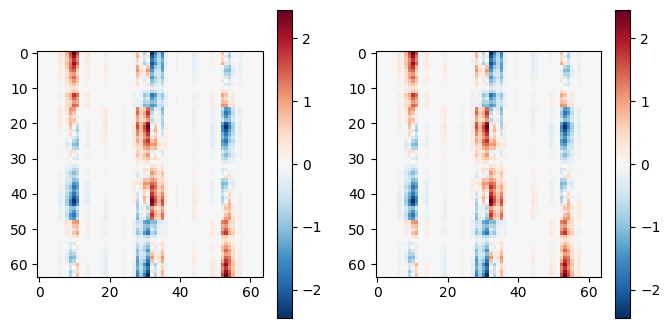

In [ ]:
mapping = RecursiveLocalMapping(nrec=3)
Z = mapping.inverse_samples(bbox=Box(xmin=-4, xmax=4, ymin=-4, ymax=4), centered=True)
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
_ = ax[0].imshow(compute_J_ab_integral(mapping, Z), cmap='RdBu_r')
fig.colorbar(_, ax=ax[0])
_ = ax[1].imshow(compute_J_ab_integral_lowrank(mapping, Z), cmap='RdBu_r')
fig.colorbar(_, ax=ax[1])
plt.show()

In [ ]:
mapping = RecursiveLocalMapping(nrec=1)
Z = mapping.inverse_samples(bbox=Box(xmin=-4, xmax=4, ymin=-4, ymax=4))

print('-- naive method --')
print(compute_J_ab_integral_naive(mapping, Z))

print('-- naive method 2 --')
print(compute_J_ab_integral_naive2(mapping, Z))

print('-- fast einsum method --')
print(compute_J_ab_integral(mapping, Z))

print('-- low rank method --')
print(compute_J_ab_integral_lowrank(mapping, Z))

-- naive method --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00000000e+00 -8.77735229e+00]
 [-8.77802046e+00 -6.68166413e-04  8.77668412e+00 -6.68166413e-04]
 [ 0.00000000e+00 -8.77735229e+00  0.00000000e+00  8.77735229e+00]]
-- naive method 2 --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00000000e+00 -8.77735229e+00]
 [-8.77802046e+00 -6.68166413e-04  8.77668412e+00 -6.68166413e-04]
 [ 0.00000000e+00 -8.77735229e+00  0.00000000e+00  8.77735229e+00]]
-- fast einsum method --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00000000e+00 -8.77735229e+00]
 [-8.77802046e+00 -6.68166413e-04  8.77668412e+00 -6.68166413e-04]
 [ 0.00000000e+00 -8.77735229e+00  0.00000000e+00  8.77735229e+00]]
-- low rank method --
[[ 8.77802046e+00  6.68166413e-04 -8.77668412e+00  6.68166413e-04]
 [ 0.00000000e+00  8.77735229e+00  0.00

simulating LowRankRNN{N=100000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:03<00:00]
simulating LowRankRNN{N=4, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=16, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=64, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=256, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=1024, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating LowRankRNN{N=4096, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]


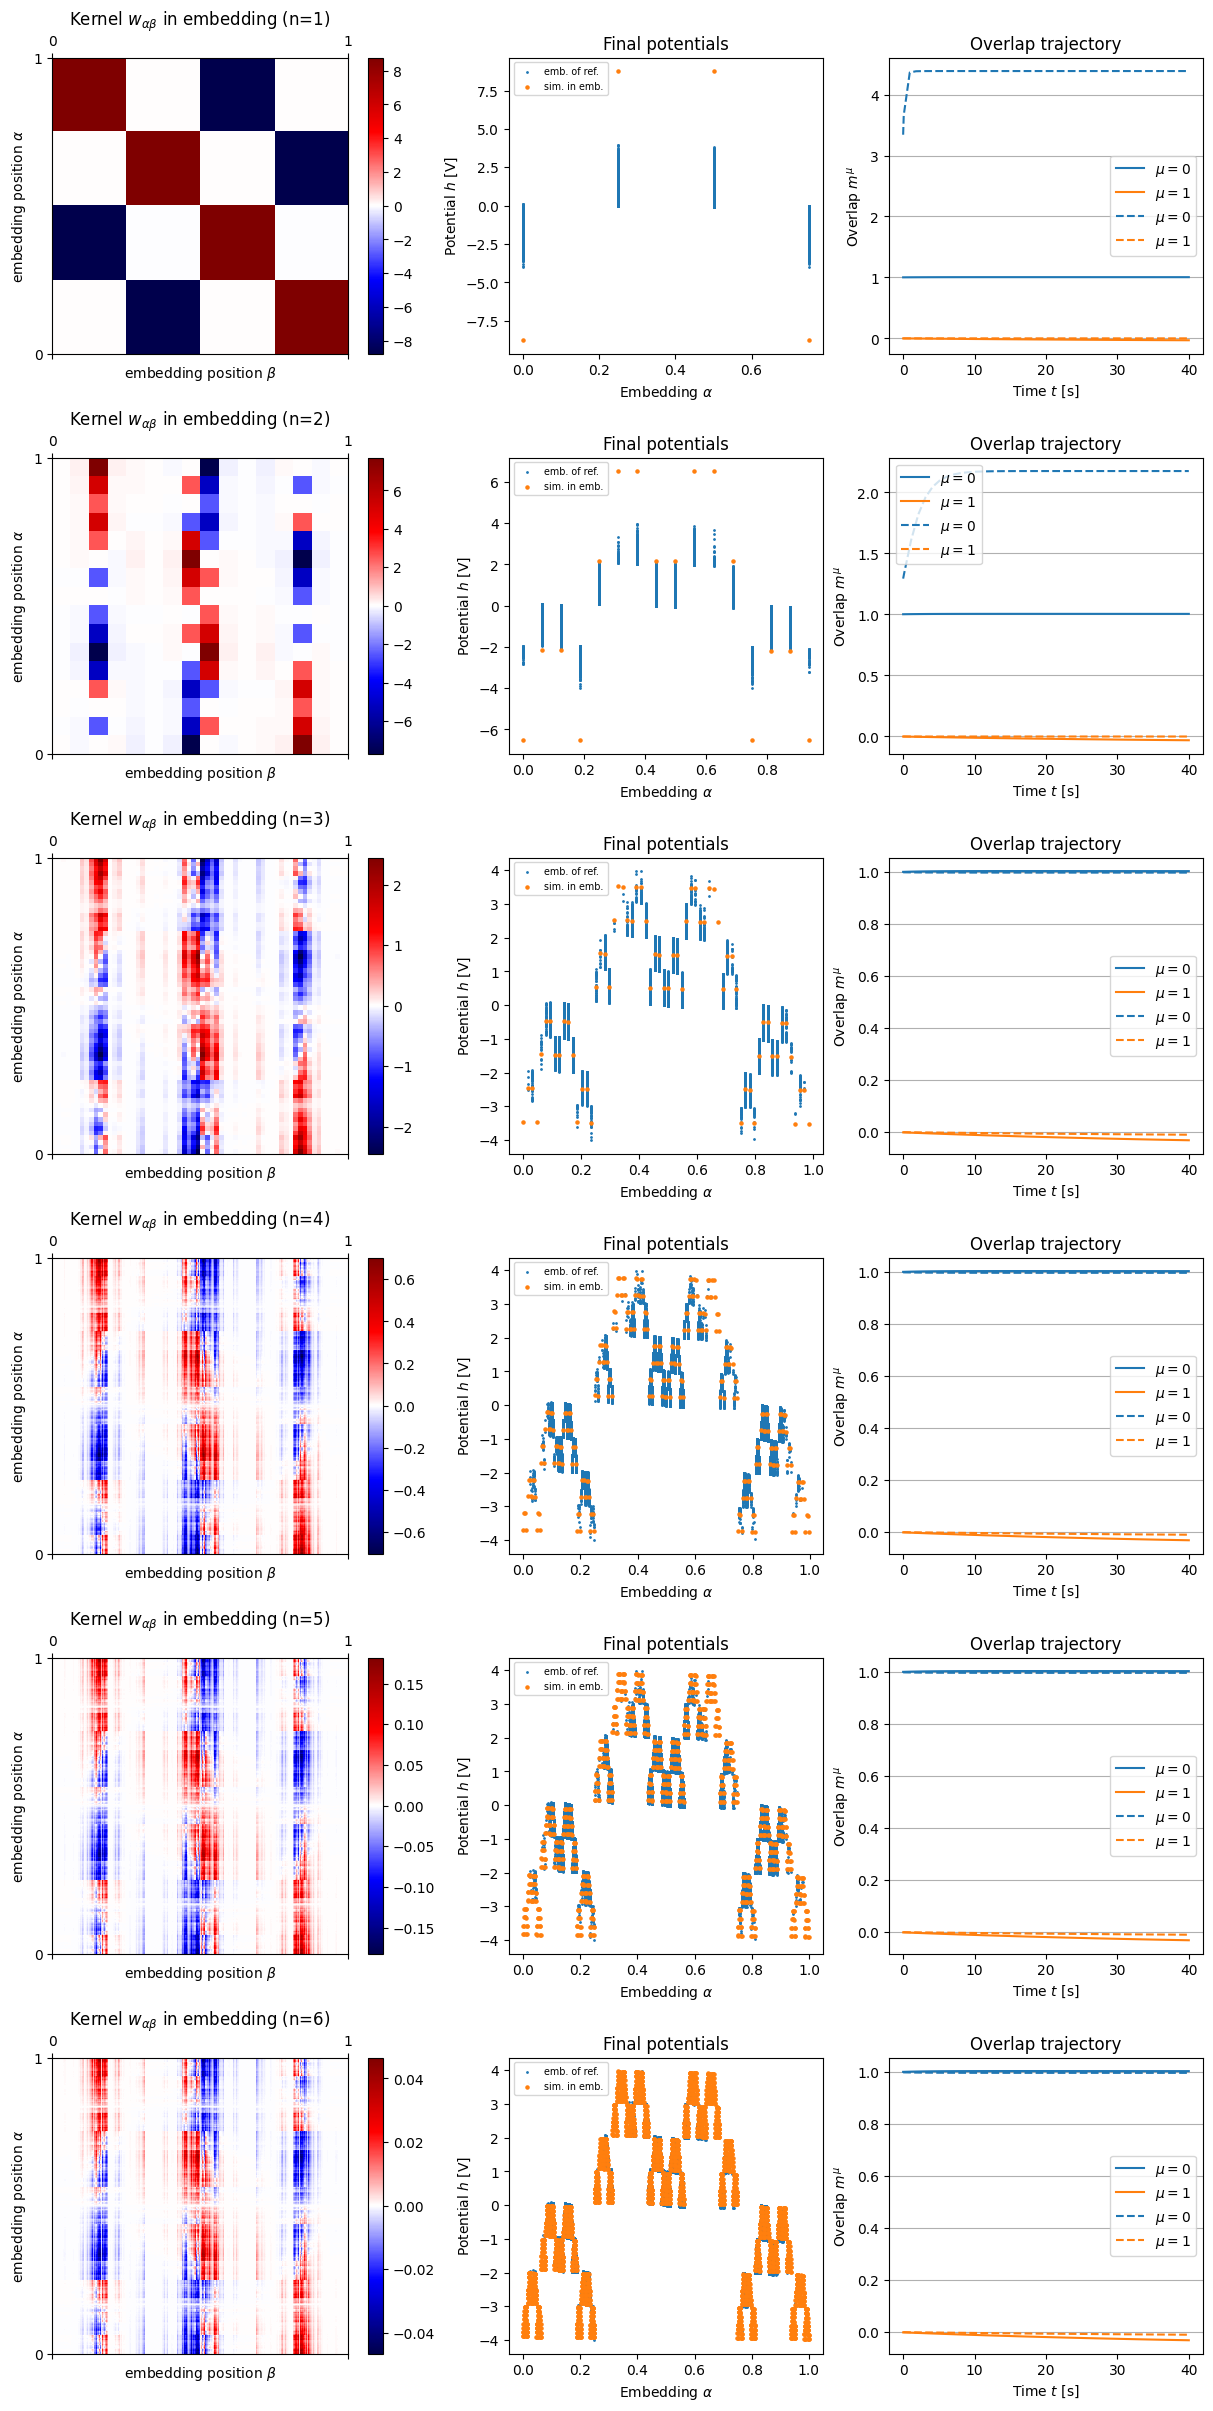

In [ ]:
# NOTE : we start from the pattern h(0)=xi^0, because the h(0)=0 condition is a bit a weird fixed point
rnn_ref = LowRankRNN.new_valentin(p=2, N=100_000, phi=sigmoid, I_ext=zero, exclude_self_connections=False)
# Initial conditions mu=0
res_ref = rnn_ref.simulate(h0=rnn_ref.F[:, 0], t_span=(0, 40), dt_max=1, progress=True)
# Initial conditions h=0
# res_ref = rnn_ref.simulate(h0=np.zeros(rnn_ref.N), t_span=(0, 40), dt_max=1, progress=True)

# ns = [1,2]
# ns = [1, 2, 3]
# ns = [1, 2, 3, 4]
ns = [1, 2, 3, 4, 5, 6]
fig, axes = plt.subplots(ncols=3, nrows=len(ns), figsize=(3*4, len(ns)*4), constrained_layout=True)

bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)  # the bbox to run the embedded simulation in

for ax, n in zip(axes, ns):
	mapping = RecursiveLocalMapping(nrec=n)
	Z = mapping.inverse_samples(bbox=Box(xmin=-4, xmax=4, ymin=-4, ymax=4))
	# J = compute_J_ab_integral(mapping, Z)

	# rnn_emb = DenseRNN(DenseRNNParams(phi=sigmoid, I_ext=zero, exclude_self_connections=False, J=J))
	# res_emb = rnn_emb.simulate(h0=Z[:, 0], t_span=(0, 40), dt_max=1, progress=True)
	# res_emb = rnn_emb.simulate(h0=np.zeros(mapping.num_bins), t_span=(0, 40), dt_max=1, progress=True)
	rnn_emb = LowRankRNN(LowRankRNNParams(
		phi=sigmoid, I_ext=zero, exclude_self_connections=False,
		# NOTE : we need to scale by mapping.num_bins, because the to_dense() method divides by N=num_bins again
		F=Z, G=phi_tilde(Z) * rho(Z)[:, None]/rho(Z).sum() * mapping.num_bins
	))
	res_emb = rnn_emb.simulate(h0=Z[:, 0], t_span=(0, 40), dt_max=1, progress=True)

	ax[0].set_title(f'Kernel $w_{{\\alpha\\beta}}$ in embedding (n={mapping.nrec})')
	ax[0].set_xlabel('embedding position $\\beta$')
	ax[0].set_ylabel('embedding position $\\alpha$')
	im = ax[0].matshow(rnn_emb.params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
	fig.colorbar(im, ax=ax[0])

	mask = bbox.contains(rnn_ref.F)  # WARNING : we need to have the same bounding box for the sampled RNN, and the integral formulation !
	ax[1].set_xlabel('Embedding $\\alpha$')
	ax[1].set_ylabel('Potential $h$ [V]')
	ax[1].set_title('Final potentials')
	ax[1].scatter(mapping(rnn_ref.F[mask], bbox=bbox), res_ref.h[mask, -1], s=1, label='emb. of ref.')
	ax[1].scatter(mapping(Z, bbox=bbox), res_emb.h[:, -1], s=5, label='sim. in emb.')
	ax[1].legend(loc='upper left', fontsize='x-small')

	plot_overlap_trajectory(rnn_ref, res_ref, figax=(fig, ax[2]))
	ax[2].set_prop_cycle(None)  # reset color cycle
	m = np.einsum('am,a...,a->m...', phi_tilde(Z), phi(res_emb.h), rho(Z)/rho(Z).sum())
	for mu in range(len(m)):
		ax[2].plot(res_emb.t, m[mu], label=f'$\\mu={mu}$', linestyle='--')
	ax[2].legend()